### Predicting ATM Fraud

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

### Use Case

The analytics use case implemented in this notebook is detecting ATM Fraud. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/rosswlewis/ATM_Fraud/master/assets/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For ATM fraud, we use historical transaction data. We also know which transactions are fraud, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "fraud" or "not fraud"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of fraud.  

### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
2. The notebook has 2 types of cells - markdown (text) and code. 
3. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
4. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
5. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

### Step 1: Load the Data

In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-8f959616-4d92-4073-bbf2-1d3f4f6ffad0',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'VYkxc-7ohgrp0zdnHRSHAQW-aqI5m-b6j8K3YBllfR4a'
}

configuration_name = 'os_1e498447d5f74cd6b90b92b35bb6514e_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('ATM_CleanData.csv', 'datascienceinbanking-donotdelete-pr-hrnb5icgks2da6'))
data.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190311232227-0000
KERNEL_ID = 3616ca8f-c80a-4cc3-b693-1b978d0fd087


[Row(ATM_ID='ATM_S0', SHORTNAM='NWST', CARDHOLD='Card_S1', FRAUD_TY='NOT FRAUDULENT', FRAUD='0', ISSUER_I='716', MAKE='TRITON', MODEL='9670.000000', FACILITI='ND S/C 100P', ATM_POSI='Petrol Station', INSTITUT='SECU', POST_COD_Town='Belfast', POST_COD_Region='Northern Ireland', Day of Week='5. Thursday', Time of Day='21', Time of Day Band='4. Evening (6pm to 10pm)'),
 Row(ATM_ID='ATM_S2', SHORTNAM='BOI', CARDHOLD='Card_S3', FRAUD_TY='NOT FRAUDULENT', FRAUD='0', ISSUER_I='152', MAKE='NCR', MODEL='5884.000000', FACILITI='ND S/C 100P', ATM_POSI='Convenience Store', INSTITUT='SECU', POST_COD_Town='Belfast', POST_COD_Region='Northern Ireland', Day of Week='6. Friday', Time of Day='21', Time of Day Band='4. Evening (6pm to 10pm)'),
 Row(ATM_ID='ATM_S4', SHORTNAM='LLDS', CARDHOLD='Card_S5', FRAUD_TY='NOT FRAUDULENT', FRAUD='0', ISSUER_I='158', MAKE='NCR', MODEL='5085.000000', FACILITI='ND S/C 100P', ATM_POSI='Supermarket', INSTITUT='SECU', POST_COD_Town='Edinburgh', POST_COD_Region='Scotland',

If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

### Step 2: Clean the Data
This step is to remove spaces from columns names, it's an example of data preparation that you may have to do before creating a model. 

In [3]:
# Rename the columns
data = data.withColumnRenamed('Day of Week','DAY_OF_WEEK')
data = data.withColumnRenamed('Time of Day','TIME_OF_DAY')
data = data.withColumnRenamed('Time of Day Band','TIME_OF_DAY_BAND')

### Step 3: Understand the Data
Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [4]:
df = data.sample(True,.1).toPandas()

In [5]:
import brunel
%brunel data('df') treemap x(DAY_OF_WEEK,TIME_OF_DAY_BAND) color(DAY_OF_WEEK) size(FRAUD) sum(FRAUD) tooltip(#all)

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


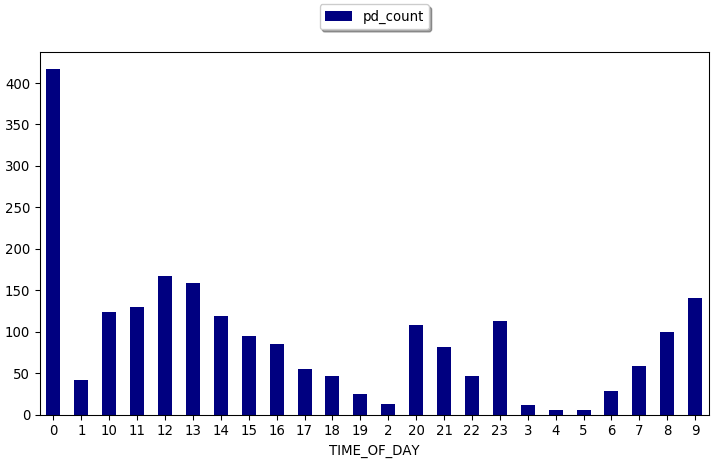

In [16]:
from pixiedust.display import *
display(df)

### Step 4: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='ATM_POSI', outputCol='positionEncoded')
SI2 = StringIndexer(inputCol='POST_COD_Region',outputCol='regionEncoded')
SI3 = StringIndexer(inputCol='DAY_OF_WEEK',outputCol='dayOfWeekEncoded')
SI4 = StringIndexer(inputCol='TIME_OF_DAY_BAND',outputCol='timeOfDayEncoded')
labelIndexer = StringIndexer(inputCol='FRAUD', outputCol='label').fit(data)

#Apply OneHotEncoder so categorical features aren't given numeric importance
OH1 = OneHotEncoder(inputCol="positionEncoded", outputCol="positionEncoded"+"classVec")
OH2 = OneHotEncoder(inputCol="regionEncoded", outputCol="regionEncoded"+"classVec")
OH3 = OneHotEncoder(inputCol="dayOfWeekEncoded", outputCol="dayOfWeekEncoded"+"classVec")
OH4 = OneHotEncoder(inputCol="timeOfDayEncoded", outputCol="timeOfDayEncoded"+"classVec")


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["positionEncoded"+"classVec", "regionEncoded"+"classVec", "dayOfWeekEncoded"+"classVec", "timeOfDayEncoded"+"classVec"],\
                            outputCol="features")

In [8]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,labelIndexer,OH1,OH2,OH3,OH4,assembler,rf,labelConverter])

In [9]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ATM_ID: string, SHORTNAM: string, CARDHOLD: string, FRAUD_TY: string, FRAUD: string, ISSUER_I: string, MAKE: string, MODEL: string, FACILITI: string, ATM_POSI: string, INSTITUT: string, POST_COD_Town: string, POST_COD_Region: string, DAY_OF_WEEK: string, TIME_OF_DAY: string, TIME_OF_DAY_BAND: string]

In [10]:
# Build models
model = pipeline.fit(train)

### Step 4: Score the test data set

In [11]:
results = model.transform(test)
results=results.select(results["label"],results["prediction"],results["FRAUD"],results['predictedLabel'],results["probability"])
results.toPandas().head(10)

,label,prediction,FRAUD,predictedLabel,probability
0,1.0,1.0,0,0,"[0.488149658751, 0.511850341249]"
1,1.0,1.0,0,0,"[0.455589945862, 0.544410054138]"
2,1.0,1.0,0,0,"[0.36010749758, 0.63989250242]"
3,1.0,1.0,0,0,"[0.338126811832, 0.661873188168]"
4,1.0,1.0,0,0,"[0.393781882592, 0.606218117408]"
5,1.0,0.0,0,1,"[0.507153569738, 0.492846430262]"
6,1.0,0.0,0,1,"[0.526942049582, 0.473057950418]"
7,1.0,1.0,0,0,"[0.338126811832, 0.661873188168]"
8,0.0,1.0,1,0,"[0.488149658751, 0.511850341249]"
9,0.0,1.0,1,0,"[0.488149658751, 0.511850341249]"


### Step 5: Model Evaluation 

In [13]:
print ('Model precision' + format(results.filter(results.label == results.prediction).count() / float(results.count())))

Model precision0.7315694255992763


In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print ('Area under ROC curve = ' + format(evaluator.evaluate(results)))

Area under ROC curve = 0.7349063708477526


We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

### Summary

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API. 


Created by **Ross Lewis**
<br/>
rwlewis@us.ibm.com
<br/>
October 3, 2017